# Getting started with Landmark Explanation

Note: you can run **[this notebook live in Google Colab](https://colab.research.google.com/github/softlab-unimore/Landmark/blob/master/quick_start_magellan.ipynb)** and use free GPUs provided by Google.

This tutorial describes how to effortlessly explaining entity matching. Specifically, we will see how to match pairs of tuples (also called data records or table rows) to determine if they refer to the same real world entity. To do so, we will need labeled examples as input, i.e., tuple pairs which have been annotated as matches or non-matches. This will be used to train a model to explain using supervised learning. After that you will apply Landmark to get an explanation of the model over a record from your data. 

In this notebook you will use the [Magellan](https://github.com/anhaidgroup/py_entitymatching) library to:

1.   Extract feature similarity between the entities of each pair.
2.   Apply a ML model over the extracted features to predict the label.



## Step 0. Setup

If you are running this notebook inside Colab, you will first need to install necessary packages by running the code below:

In [1]:
!pip install py_entitymatching

You may need to restart the kernel to use Magellan. That's OK.


### clone landmark code

In [2]:
!git clone https://github.com/softlab-unimore/landmark.git
!pip install -r landmark/requirements.txt

fatal: destination path 'landmark' already exists and is not an empty directory.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import py_entitymatching as em # magellan

### Load data for entity matching

Now let's get some sample data to play with in this tutorial.

1. **Training Data:** This is used for training the model.
2. **Test Data:** We explain the behavior of the model over a record from the test.

In [4]:
!mkdir -p sample_data/abt-buy
!wget -qnc -P sample_data/abt-buy https://pages.cs.wisc.edu/~anhai/data1/deepmatcher_data/Textual/Abt-Buy/exp_data/tableA.csv
!wget -qnc -P sample_data/abt-buy https://pages.cs.wisc.edu/~anhai/data1/deepmatcher_data/Textual/Abt-Buy/exp_data/tableB.csv
!wget -qnc -P sample_data/abt-buy https://pages.cs.wisc.edu/~anhai/data1/deepmatcher_data/Textual/Abt-Buy/exp_data/test.csv
!wget -qnc -P sample_data/abt-buy https://pages.cs.wisc.edu/~anhai/data1/deepmatcher_data/Textual/Abt-Buy/exp_data/train.csv
!wget -qnc -P sample_data/abt-buy https://pages.cs.wisc.edu/~anhai/data1/deepmatcher_data/Textual/Abt-Buy/exp_data/valid.csv

In [5]:

dataset_path = '/content/sample_data/abt-buy/'
DA = em.read_csv_metadata(dataset_path + 'tableA.csv', key='id')[['id','name']]
DB = em.read_csv_metadata(dataset_path + 'tableB.csv', key='id')[['id','name']]

# simplified_columns = ['id','left_id','right_id','label','left_name','right_name']
train = pd.read_csv(dataset_path + 'train.csv')
train['id'] = train.index
test = pd.read_csv(dataset_path + 'test.csv')
test['id'] = test.index

exclude_attrs=['id','left_id','right_id', 'label']

Metadata file is not present in the given path; proceeding to read the csv file.
Metadata file is not present in the given path; proceeding to read the csv file.


## Step 1. Magellan for Entity Matching

In [6]:
# Magellan catalog declaration
em.set_key(train, 'id')
em.set_key(DA, 'id')
em.set_key(DB, 'id')
em.set_ltable(train, DA)
em.set_rtable(train, DB)
em.set_fk_ltable(train, 'ltable_id')
em.set_fk_rtable(train, 'rtable_id')

True

### Magellan Feature extraction

In [7]:
feature_table = em.get_features_for_matching(DA[['name']],DB[['name']], validate_inferred_attr_types=False)
feature_table.head()

,feature_name,left_attribute,right_attribute,left_attr_tokenizer,right_attr_tokenizer,simfunction,function,function_source,is_auto_generated
0,name_name_jac_qgm_3_qgm_3,name,name,qgm_3,qgm_3,jaccard,<function name_name_jac_qgm_3_qgm_3 at 0x7f2f103dbb90>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
1,name_name_cos_dlm_dc0_dlm_dc0,name,name,dlm_dc0,dlm_dc0,cosine,<function name_name_cos_dlm_dc0_dlm_dc0 at 0x7f2ee52ec170>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
2,name_name_mel,name,name,None,None,monge_elkan,<function name_name_mel at 0x7f2ee52ec4d0>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
3,name_name_lev_dist,name,name,None,None,lev_dist,<function name_name_lev_dist at 0x7f2ee52ec5f0>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
4,name_name_lev_sim,name,name,None,None,lev_sim,<function name_name_lev_sim at 0x7f2ee52ec710>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True


In [8]:
similarity_features = em.extract_feature_vecs(train, feature_table=feature_table, )
similarity_features = similarity_features.fillna(similarity_features.mean())

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


In [9]:
similarity_features.head()

,id,ltable_id,rtable_id,name_name_jac_qgm_3_qgm_3,name_name_cos_dlm_dc0_dlm_dc0,name_name_mel,name_name_lev_dist,name_name_lev_sim
0,0,730,775,0.280488,0.404520,0.733421,41.0,0.405797
1,1,670,820,0.306122,0.500000,0.832693,40.0,0.393939
2,2,497,239,0.315789,0.365148,0.825192,18.0,0.590909
3,3,644,299,0.286957,0.436436,0.806738,62.0,0.354167
4,4,464,32,0.212121,0.365148,0.835151,25.0,0.444444


### Model Training over extracted featurs

In [10]:
X = similarity_features.iloc[:, 3:]
y = train['label']
model = em.LogRegMatcher(name='LR', random_state=0, n_jobs=-1,
                         C=0.5, max_iter=100, class_weight={0: 1, 1:3})


test_precision    0.461363
test_recall       0.456029
test_f1           0.456696
dtype: float64

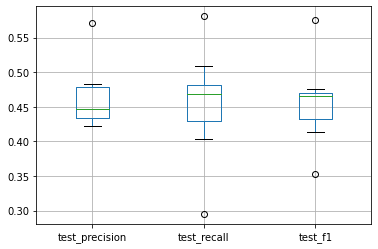

In [11]:
from sklearn.model_selection import cross_validate

scores = pd.DataFrame(cross_validate(model.clf, X, y, cv=10, scoring=('precision', 'recall', 'f1')))
scores = scores.iloc[:,-3:] # remove time measures
scores.boxplot()
scores.mean()

In [12]:
model.fit(X,y)

## Step2. Explanation using Landmark

In [13]:
# The explainer takes a predict method to analyse its behavior. 
# To this end I prepared for you a wrapper for the magellan feature extraction and model prediction.
from landmark.wrapper.MagellanWrapper import MagellanWrapper
mg_wrapped = MagellanWrapper(model, feature_table, exclude_attrs)

In [14]:
test_merged = test.copy()
for df, prefix in [(DA.copy(), 'left_'), (DB.copy(), 'right_')]:
    df.columns = prefix + df.columns
    test_merged = test_merged.merge(df, left_on = 'ltable_id', right_on=prefix +'id', suffixes=('',''))
test_merged = test_merged.drop(['ltable_id','rtable_id'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [15]:
test_merged

,label,id,left_id,left_name,right_id,right_name
0,0,0,445,sony pink cyber-shot 7.2 megapixel digital camera dscw120p,445,sony lcs-csj soft camera case lcscsj
1,0,715,445,sony pink cyber-shot 7.2 megapixel digital camera dscw120p,445,sony lcs-csj soft camera case lcscsj
2,0,1857,445,sony pink cyber-shot 7.2 megapixel digital camera dscw120p,445,sony lcs-csj soft camera case lcscsj
3,0,1,719,lg 2.0 cu . ft. over-the-range white microwave oven lmvm2085wh,719,samsung 6 series ln32a650 32 ' lcd tv
4,0,198,719,lg 2.0 cu . ft. over-the-range white microwave oven lmvm2085wh,719,samsung 6 series ln32a650 32 ' lcd tv
...,...,...,...,...,...,...
1911,0,1882,248,microsoft office home and student 2007 for windows vista 79g00007,248,olympus slim leather case 202087
1912,1,1893,111,nikon 18-200mm nikkor zoom lens black finish 2159,111,audiovox xm6 outdoor home antenna xm-6
1913,1,1895,76,nikon af speedlight accessory sb600,76,weber 848001 performer 22.5 ' charcoal grill in dark blue
1914,0,1900,11,panasonic 2-line integrated telephone system kxts208w,11,linksys g wireless-g wet54g wireless bridge


In [16]:
preds = mg_wrapped.predict(test_merged)
test_merged['pred'] = preds

Select an item to explain.

In [17]:
el = test_merged[test_merged.id==270]
display(el)

,label,id,left_id,left_name,right_id,right_name,pred
25,0,270,808,canon black rechargeable battery 9612a001,808,samsung yp-s2zw 1gb flash mp3 player yp-s2zg / xaa,0.005569


### Explain a NO-MATCH item with token injection mechanism
Call explain to generate the explanation.

---


By default the **conf** parameter is set to 'auto' it means that the perturbation strategy depends on the label (that must exist in the DataFrame columns). 

*   If label == 1 --> *single* perturbation with landmark.
*   If label == 0 --> *double* perturbation with landmark. (*double* means that we inject tokens from the landmark description into the perturbed description) see the paper for more.

In [18]:
from landmark import Landmark
explainer = Landmark(mg_wrapped.predict, test_merged, exclude_attrs=exclude_attrs, lprefix='left_', rprefix='right_', split_expression=r' ')

In [19]:
%%time
exp = explainer.explain(el)

CPU times: user 1.92 s, sys: 44.5 ms, total: 1.97 s
Wall time: 1.93 s


In [20]:
exp

,index,id,column,position,word,word_prefix,impact,conf
0,0,270,left_name,5,samsung,A05_samsung,0.170598,right_landmark_injection
1,1,270,left_name,10,player,A10_player,0.132149,right_landmark_injection
2,2,270,left_name,6,yp-s2zw,A06_yp-s2zw,0.129104,right_landmark_injection
3,3,270,left_name,8,flash,A08_flash,0.128184,right_landmark_injection
4,4,270,left_name,13,xaa,A13_xaa,0.121889,right_landmark_injection
5,5,270,left_name,9,mp3,A09_mp3,0.100621,right_landmark_injection
6,6,270,left_name,7,1gb,A07_1gb,0.095752,right_landmark_injection
7,7,270,left_name,2,rechargeable,A02_rechargeable,-0.087016,right_landmark_injection
8,8,270,left_name,4,9612a001,A04_9612a001,-0.071572,right_landmark_injection
9,9,270,left_name,11,yp-s2zg,A11_yp-s2zg,0.069753,right_landmark_injection


,label,id,left_id,left_name,right_id,right_name,pred
25,0,270,808,canon black rechargeable battery 9612a001,808,samsung yp-s2zw 1gb flash mp3 player yp-s2zg / xaa,0.005569


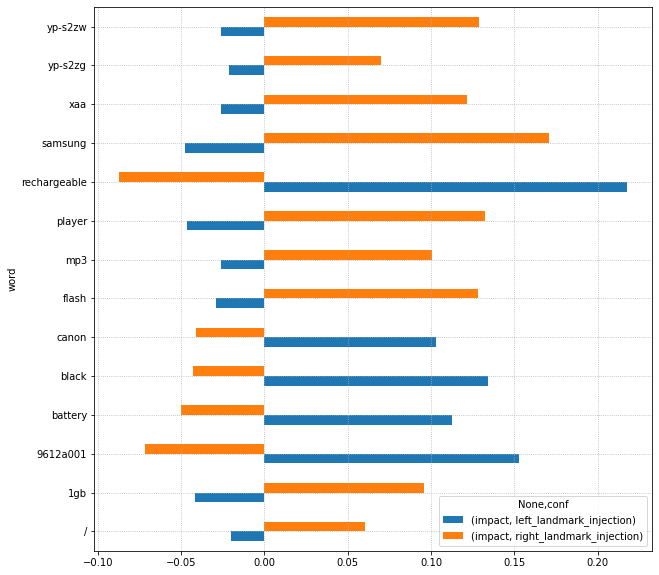

In [21]:
to_plot = exp
figsize = (10,10)
aggregated = to_plot.pivot_table(index='word',values=['impact'],columns=['conf'], aggfunc='max' )
plot = aggregated.plot(kind='barh', figsize=figsize,)
plt.gca().grid(True, linestyle=':', axis='both')
el

/content/landmark/landmark/landmark.py:284: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  view.drop('impact', 1, inplace=True)


,left_name,right_name
25,canon black rechargeable battery 9612a001,samsung yp-s2zw 1gb flash mp3 player yp-s2zg / xaa


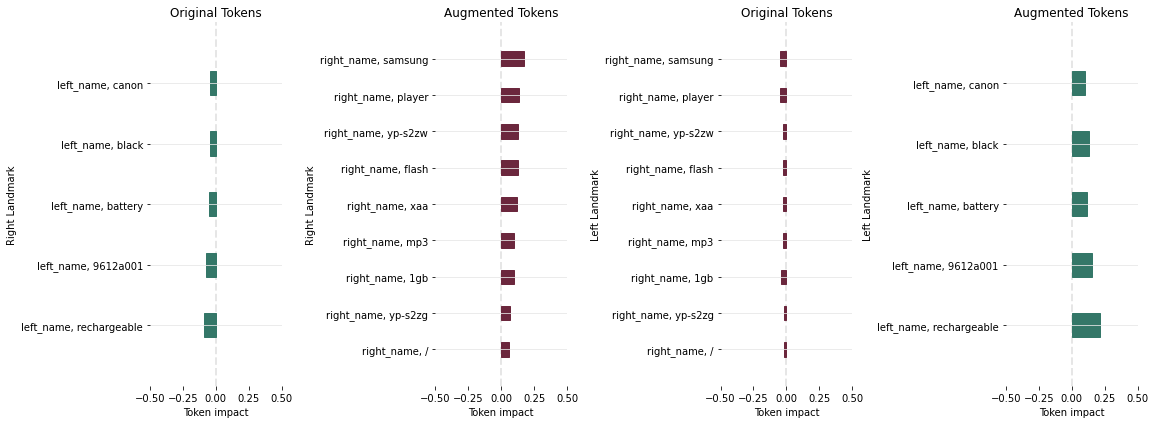

In [22]:
explainer.plot(exp, el)
el[['left_name','right_name']]

In [23]:
explainer.double_explanation_conversion(exp, el)

/content/landmark/landmark/landmark.py:284: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  view.drop('impact', 1, inplace=True)


,column,position,word,score_right_landmark,score_left_landmark
7,left_name,2,rechargeable,-0.087016,0.217482
8,left_name,4,9612a001,-0.071572,0.153048
11,left_name,3,battery,-0.049934,0.112385
12,left_name,1,black,-0.042897,0.134485
13,left_name,0,canon,-0.041146,0.103191
19,right_name,0,samsung,0.170598,-0.047586
20,right_name,5,player,0.132149,-0.046742
21,right_name,2,1gb,0.095752,-0.041638
22,right_name,3,flash,0.128184,-0.029298
23,right_name,1,yp-s2zw,0.129104,-0.026038


### NO-MATCH with 'single' mechanism

In [24]:
exp = explainer.explain(el, conf='single')

/content/landmark/landmark/landmark.py:284: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  view.drop('impact', 1, inplace=True)


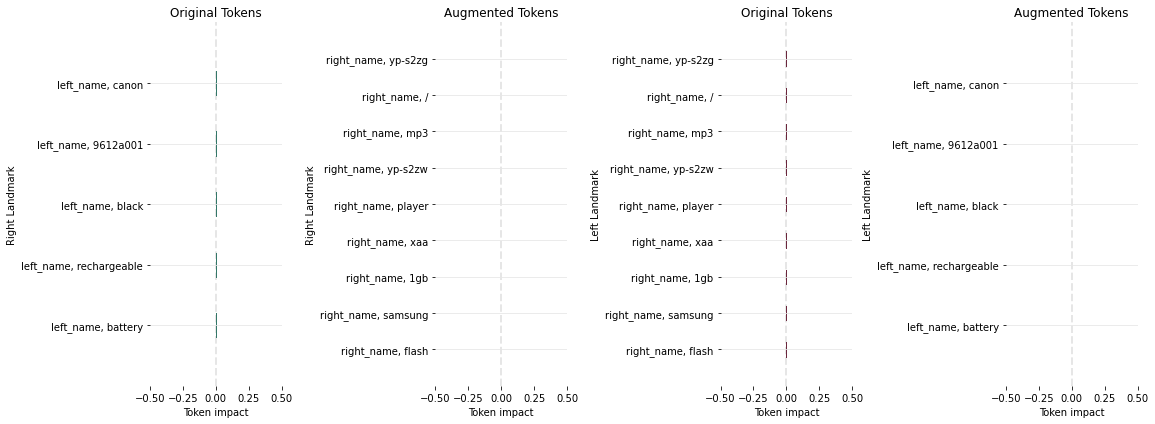

In [25]:
explainer.plot(exp, el) # No augmented (injected) tokens

,label,id,left_id,left_name,right_id,right_name,pred
25,0,270,808,canon black rechargeable battery 9612a001,808,samsung yp-s2zw 1gb flash mp3 player yp-s2zg / xaa,0.005569


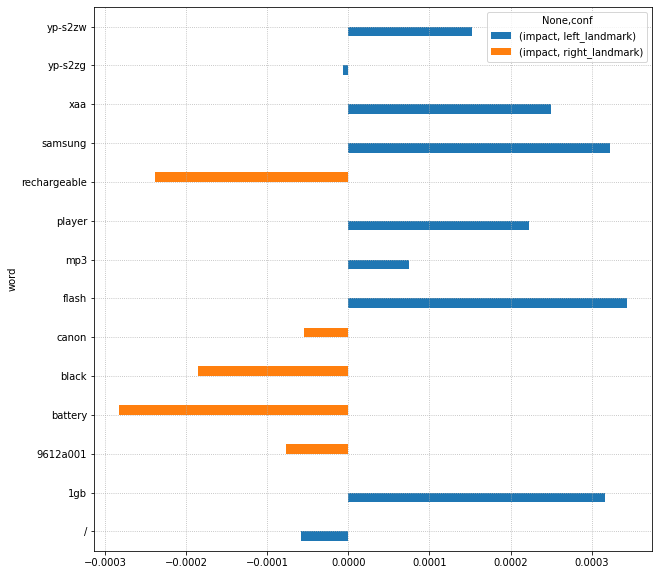

In [26]:
to_plot = exp
figsize = (10,10)
aggregated = to_plot.pivot_table(index='word',values=['impact'],columns=['conf'], aggfunc='max' )
plot = aggregated.plot(kind='barh', figsize=figsize,)
plt.gca().grid(True, linestyle=':', axis='both')
el